In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Introduction

In the last notebook we looked at data that had already been seasonally adjusted by the statistical agency. In this notebook, we will look at what to do if you can't get seasonally adjusted data.

# Getting Data

For this exercise we'll use non-seasonally adjusted quarterly US government tax receipts, which comes from FRED series NA000327Q.

In [3]:
# from pandas_datareader.fred import FredReader

# data = FredReader('NA000327Q', start='1900', end='2023').read()
# data.to_csv('tax_recepits.csv')

We can just grab the data with FredReader and be done, but lets pretend like we're loading it from the disk to practice using `pd.read_csv`. Remember to use `parse_dates`, `infer_datetime_format`, and `index_col`

In [4]:
df = pd.read_csv('tax_recepits.csv', parse_dates=['DATE'], infer_datetime_format=True, index_col='DATE')
df.head()

,NA000327Q
DATE,
1947-01-01,12306.0
1947-04-01,7607.0
1947-07-01,8543.0
1947-10-01,8590.0
1948-01-01,12888.0


In [5]:
df.columns = ['tax_income']

Plotting the series, there's a clear upward (quadratic?) trend, and a lot of wiggling in the line. All that wiggling, even at this scale, is a tell-tale sign of seasonality.

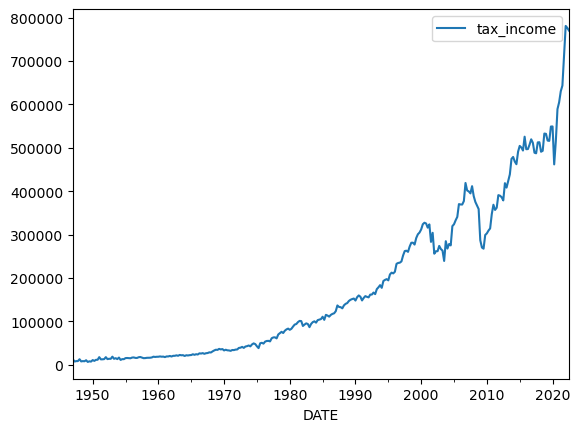

In [6]:
df.plot();

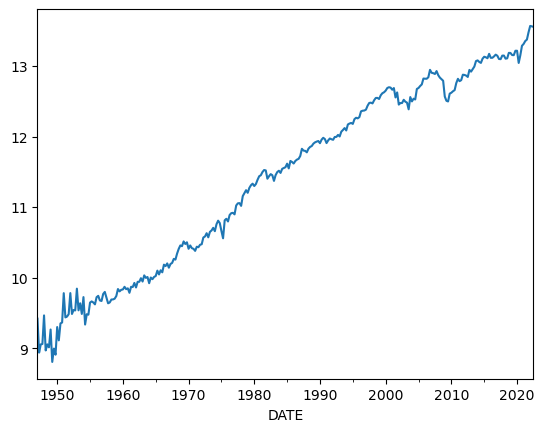

In [7]:
df.tax_income.map(np.log).plot();

One easy way to remove a trend is by taking differences. If we have data with a trend and noise, like:

$$y_t = \alpha + \beta \cdot t + \epsilon_t$$

Then if we subtract $y_t - y_{t-1}$ we remove the trend, because:

$$y_t - y_{t-1} = \alpha - \alpha + \beta \cdot t - \beta \cdot (t-1) + \epsilon_t - \epsilon_{t-1}$$

Define $\Delta x_t = x_t - x_{t-1}$, so we get:

$$\Delta y_t = \beta t - \beta t + \beta + \Delta \epsilon_t = \beta + \Delta \epsilon_t$$

I distributed $\beta (t - 1) = \beta t - \beta$ there as well. So as you can see, if we take first differences, the trend goes away and the slope of the trend becomes the new constant. Let's take differences of the tax income by using the `.diff()` method.

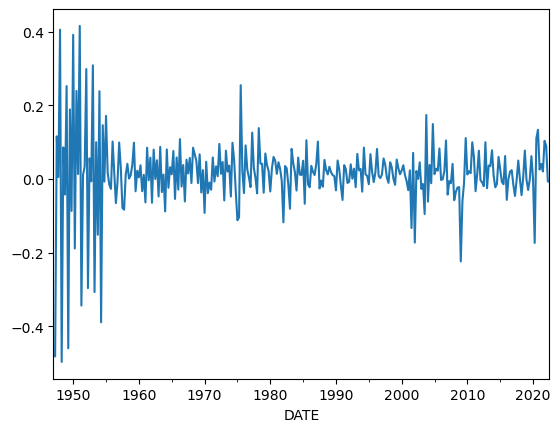

In [8]:
df.tax_income.map(np.log).diff().plot();

Now we should be really suspicious. This doesn't look like white noise at all, it looks like it's bouncing up and down in a repeating pattern. This is exactly the definition of seasonality. We'll need to do something about it.

## Looking for seasonal effects

One nice way to check for a seasonal effect is to plot each full season as a separate line together on one plot.

To do this, we will need to use a pivot table. A pivot table is exaclty like Excel, and it's one of the most powerful things you can do with Pandas. It allows us to arbitrarily reshape the dataframe according to values in the data.

What we want is to change everything so that the index is quarter, and the columns are the years. Then, each column of the data will be 4 values, and we can call `.plot` to see if there is a quarterly pattern common to all the years.

First, let's save the logged and differenced data to its own dataframe.

In [9]:
df['log_tax'] = df.tax_income.map(np.log)
df['diff_log_tax'] = df.log_tax.diff()
d_log_tax = df[['diff_log_tax']]

Because we have a `DatetimeIndex`, we can access special time properties on the index. These include `.day`, `.month`, `.quarter`, `.year`, and many many more. Check the docs.

We want the index of the new dataframe to be the quarter, and the columns to be the years. So we just call `df.pivot_table` and tell it what we want.

In [10]:
dtax_pivot = d_log_tax.pivot_table(index = d_log_tax.index.quarter,
                      columns = d_log_tax.index.year).head()
dtax_pivot.head()

diff_log_tax                                                              \
DATE         1947      1948      1949      1950      1951      1952      1953   
DATE                                                                            
1             NaN  0.405698  0.252574  0.391738  0.415879  0.298714  0.308867   
2       -0.481018 -0.496548 -0.459501 -0.188399 -0.343403 -0.296125 -0.306988   
3        0.116043  0.085948  0.189201  0.239345  0.011585  0.056330  0.100083   
4        0.005487 -0.042051 -0.086605  0.013650  0.034122 -0.006273 -0.151259   

                                    ...                                \
DATE      1954      1955      1956  ...      2013      2014      2015   
DATE                                ...                                 
1     0.238526  0.171547  0.101851  ... -0.024846  0.009376  0.027304   
2    -0.388960  0.016876  0.018641  ...  0.036760 -0.022341 -0.007359   
3     0.146322 -0.015260 -0.065315  ...  0.035240 -0.013278 -0.014008   
4    -0.006814 -0.026581 -0.007436  ...  0.078228  0.060100  0.062528   

                                                                            
DATE      2016      2017      2018      2019      2020      2021      2022  
DATE                                                                        
1    -0.056426 -0.015390  0.000798 -0.001185  0.000310  0.026015  0.089876  
2     0.000698 -0.045856 -0.043718 -0.029588 -0.173366  0.041211 -0.006006  
3     0.020071 -0.002830  0.004385 -0.001472  0.110006  0.020591 -0.007832  
4     0.024142  0.050295  0.077503  0.062189  0.133716  0.103853       NaN  

[4 rows x 76 columns]

Loooks like there are two groups of years. One group has a really strong seaonal effect: up in Q1, down in Q2, up in Q3, down in Q4. The other group has a smaller seasonality, but it looks like it's down in Q1, up in Q2, down in Q3, up in Q4.

What's important, though, is that we can see this grouping together. If there was no quarterly seasonality, this plot would just be chaotic nonsense.

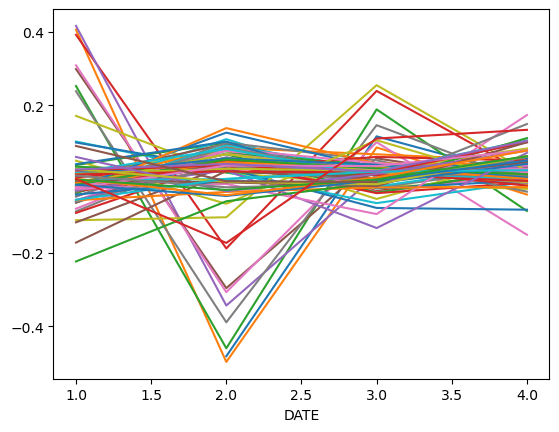

In [11]:
dtax_pivot.plot(legend=False);

Another way to look for seasonal effects is to use a *periodogram*. This takes a fourier decomposition of the data and plots the strength of each frequency. 

Basically, we want to look for spikes in the graph. A spike is a strong frequency, and a strong frequency means a seasonal effect at that frequency.

We need stationary data when we use `scipy.signal.periodogram`, so we can use the differenced data, which (as we saw) has the effect of detrending the data. The `window` argument gives a special weighting function to make the endpoints less important. These plots tend to be very nosiy around the endpoints, so this is important to getting a usable result. 

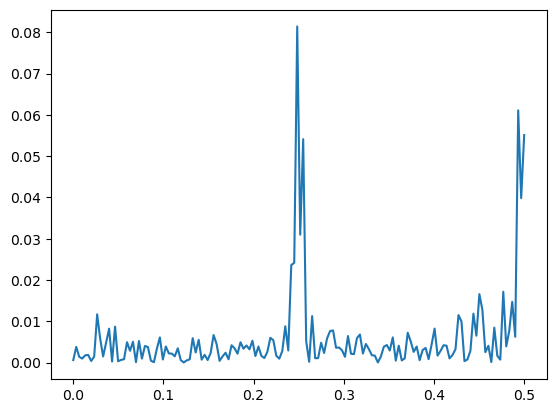

In [12]:
from scipy.signal import periodogram

freq, Pxx = periodogram(df.diff_log_tax.dropna(), window='triang')
plt.plot(freq, Pxx)

There's a super massive spike right in the middle at freq=0.25, so there's definitely seasonality. To find out where it is, we want to take the inverse of the frequency at the spike.

To get the spike, use `Pxx.argmax()`. That returns the index of the max value. As expected, it's quarterly seasonality.

In [13]:
1 / freq[Pxx.argmax()]

4.026666666666666

To see the top n spikes, we can use `.argsort()` instead. `argsort` sorts from smallest to biggest, so we need to reverse the ordering.

In [14]:
1 / freq[Pxx.argsort()[::-1][:5]]

array([4.02666667, 2.02684564, 2.        , 3.92207792, 2.01333333])

# Removing the Seasonal Effect

## Option 1: OLS

As before, we can use OLS to soak up the season and the trend together. We start by making the constant and trend design matrix we used in the other notebook.

In [15]:
# Save the number of observations as a variable
T = df.shape[0]

# Make the design matrix with np.ones and np.arange
X = np.c_[np.ones(T), np.arange(T)]

# Make it a dataframe for nice regression table output
X = pd.DataFrame(X, index=df.index, columns=['Constant', 'Trend'])
X.head()

,Constant,Trend
DATE,,
1947-01-01,1.0,0.0
1947-04-01,1.0,1.0
1947-07-01,1.0,2.0
1947-10-01,1.0,3.0
1948-01-01,1.0,4.0


In [16]:
import statsmodels.api as sm
mod = sm.OLS(df.log_tax, X, hasconst=True, missing='drop')
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_tax   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.458e+04
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          5.30e-257
Time:                        18:07:29   Log-Likelihood:                 76.589
No. Observations:                 303   AIC:                            -149.2
Df Residuals:                     301   BIC:                            -141.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       9.1478      0.022    423.308      0.000       9.105       9.190
Trend          0.0150      0.000    120.734      0.000       0.015       0.015
==============================================================================
Omnibus:                       36.813   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.447
Skew:                          -0.003   Prob(JB):                      0.00539
Kurtosis:                       2.090   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: xlabel='DATE'>

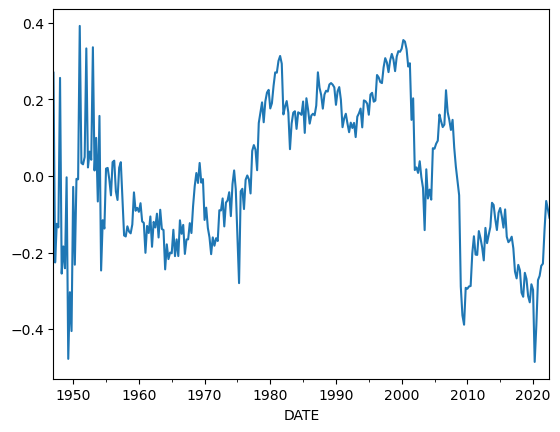

In [17]:
res.resid.plot()

Just taking out the constant and trend doesn't cut it. We need to add some things to our design matrix to account for the seasonality.

### Option 1A: Quarterly Dummies

Seasonality basically means that January is always higher BECAUSE it is January. So we can remove that by adding features to our regression that allow Januaries to be different from the other months. This is done with dummy variables.

To make quarterly dummies, we first need to make quarters. We can do that with the `.quarterly` property of `DatetimeIndex`. This is only possible because we used `parse_dates` when we loaded our data!

In [18]:
df['quarter'] = df.index.quarter
df.head()

,tax_income,log_tax,diff_log_tax,quarter
DATE,,,,
1947-01-01,12306.0,9.417842,NaN,1
1947-04-01,7607.0,8.936824,-0.481018,2
1947-07-01,8543.0,9.052868,0.116043,3
1947-10-01,8590.0,9.058354,0.005487,4
1948-01-01,12888.0,9.464052,0.405698,1


Once we have our quarterly column, we can make dummies using `pd.get_dummies`. We just pass the dataframe and the list of columns we want to make dummies out of. It returns a dataframe with 1) all the columns we did NOT ask for as dummies, and 2) all the dummy columns.

In [19]:
df_dummy = pd.get_dummies(df, columns=['quarter'])
df_dummy.head()

,tax_income,log_tax,diff_log_tax,quarter_1,quarter_2,quarter_3,quarter_4
DATE,,,,,,,
1947-01-01,12306.0,9.417842,NaN,1,0,0,0
1947-04-01,7607.0,8.936824,-0.481018,0,1,0,0
1947-07-01,8543.0,9.052868,0.116043,0,0,1,0
1947-10-01,8590.0,9.058354,0.005487,0,0,0,1
1948-01-01,12888.0,9.464052,0.405698,1,0,0,0


We know that if we have k dummy values, we can only include k-1 in the regression, because of multicolinearity. So we need to drop one column.

We can do that with `df.drop`, and pass the `columns` argument with a list of column to drop. Let's drop quarter_1.

In [20]:
df_dummy.drop(columns=['quarter_1'])

,tax_income,log_tax,diff_log_tax,quarter_2,quarter_3,quarter_4
DATE,,,,,,
1947-01-01,12306.0,9.417842,NaN,0,0,0
1947-04-01,7607.0,8.936824,-0.481018,1,0,0
1947-07-01,8543.0,9.052868,0.116043,0,1,0
1947-10-01,8590.0,9.058354,0.005487,0,0,1
1948-01-01,12888.0,9.464052,0.405698,0,0,0
...,...,...,...,...,...,...
2021-07-01,643227.0,13.374253,0.020591,0,1,0
2021-10-01,713620.0,13.478106,0.103853,0,0,1
2022-01-01,780728.0,13.567982,0.089876,0,0,0


If we don't care which column is dropped, we can pass `drop_first=True` to `pd.get_dummies`. It will drop the first alphabetical value among all the dummies. In our case we don't care, so we can use this.

We also don't want all those other columns, so we 1) just pick a single column from the dataframe, quater, and 2) ask for dummies from this column.

In [21]:
df_dummies = pd.get_dummies(df[['quarter']], columns=['quarter'], drop_first=True)
df_dummies.head()

,quarter_2,quarter_3,quarter_4
DATE,,,
1947-01-01,0,0,0
1947-04-01,1,0,0
1947-07-01,0,1,0
1947-10-01,0,0,1
1948-01-01,0,0,0


Next, we need to add these dummies to the design matrix. `df.join` combines two dataframes by matching up the indices.

In [22]:
X = X.join(df_dummies)
X.head()

,Constant,Trend,quarter_2,quarter_3,quarter_4
DATE,,,,,
1947-01-01,1.0,0.0,0,0,0
1947-04-01,1.0,1.0,1,0,0
1947-07-01,1.0,2.0,0,1,0
1947-10-01,1.0,3.0,0,0,1
1948-01-01,1.0,4.0,0,0,0


In [23]:
seasonal_mod = sm.OLS(df.tax_income.map(np.log), X, hasconst=True)
seasonal_res = seasonal_mod.fit()
seasonal_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tax_income   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3617.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          4.07e-251
Time:                        18:07:29   Log-Likelihood:                 76.955
No. Observations:                 303   AIC:                            -143.9
Df Residuals:                     298   BIC:                            -125.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       9.1585      0.029    320.012      0.000       9.102       9.215
Trend          0.0150      0.000    120.277      0.000       0.015       0.015
quarter_2     -0.0223      0.031     -0.725      0.469      -0.083       0.038
quarter_3     -0.0171      0.031     -0.559      0.577      -0.078       0.043
quarter_4     -0.0036      0.031     -0.115      0.908      -0.064       0.057
==============================================================================
Omnibus:                       41.062   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.999
Skew:                           0.006   Prob(JB):                      0.00409
Kurtosis:                       2.067   Cond. No.                         774.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot: xlabel='DATE'>

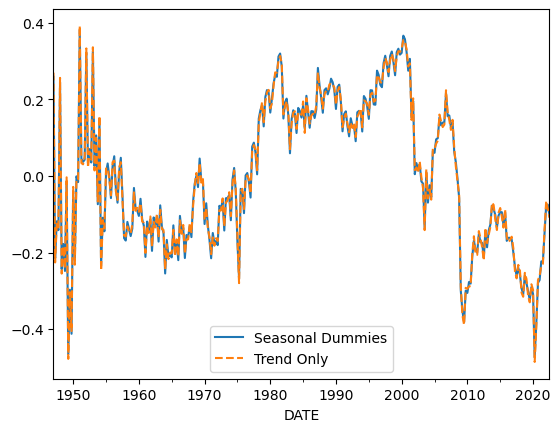

In [24]:
seasonal_res.resid.plot(label='Seasonal Dummies', legend=True)
res.resid.plot(ls='--', label='Trend Only', legend=True)

I use `.to_frame()` here beacause `reasonal_res` is a `pd.Series`, and only `pd.DataFrame` can do `pivot_table`.

<AxesSubplot: xlabel='DATE'>

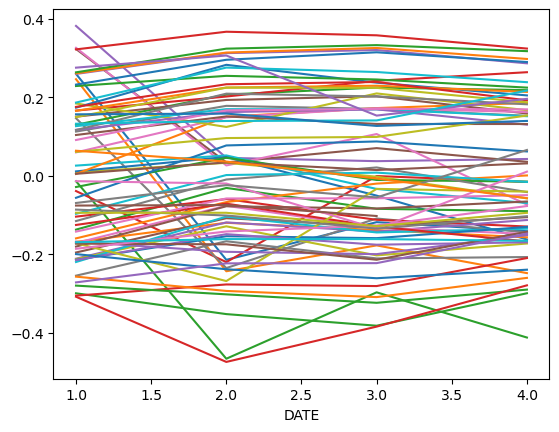

In [25]:
seasonal_res.resid.to_frame().pivot_table(index=seasonal_res.resid.index.quarter,
                                          columns=seasonal_res.resid.index.year).plot(legend=False)

To see the seasonal effect we removed, we can plot the predicted values of the model. We can see that the seasonal "waves" are quite small.

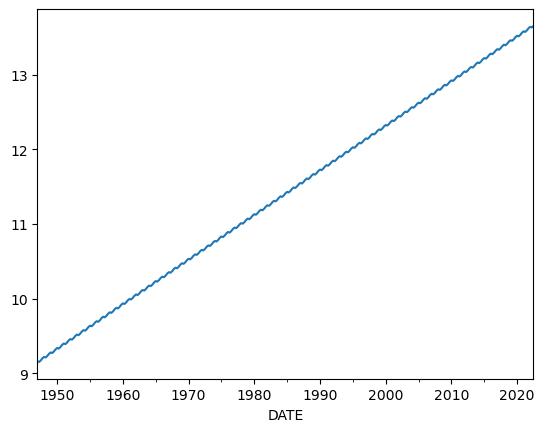

In [26]:
seasonal_res.predict(X).plot();

## Trying to do a bit better than this

You might be dissapointed with how the quarterly dummies turned out. I was, to be honest. One thing i notice from the seasonal plot (the one with lots of lines) is that there is some heterogeneity. There are a couple years with strong seasonal effects, and others where it is weaker. Among the weaker, there seems to be two distinct patterns: up, down, up, down or down, up, down up.

One way to improve might be to let the season change every year. We'd add year dummies, then interact them with the seasonal dummies. The problem is that we would have too many parameters: 3 * N_years interactions. So instead of yearly dummies, I'll try decade dummies.

In [34]:
# in python, // is integer division, so x // y = int(x) 
# This will change the last diget of every year to a 0.

df['decade'] = df.index.year // 10 * 10
df

,tax_income,log_tax,diff_log_tax,quarter,decade
DATE,,,,,
1947-01-01,12306.0,9.417842,NaN,1,1940
1947-04-01,7607.0,8.936824,-0.481018,2,1940
1947-07-01,8543.0,9.052868,0.116043,3,1940
1947-10-01,8590.0,9.058354,0.005487,4,1940
1948-01-01,12888.0,9.464052,0.405698,1,1940
...,...,...,...,...,...
2021-07-01,643227.0,13.374253,0.020591,3,2020
2021-10-01,713620.0,13.478106,0.103853,4,2020
2022-01-01,780728.0,13.567982,0.089876,1,2020


Instead of doing all that work to get dummies etc etc, we'll just use a `patsy` formula. Patsy is a package for writing down statistical models. It works a lot like the formulas in R.

Basically you use ~ as an equal sign, and write your regression using the names of columns. Then give the dataframe the columns come from.

It also has some special features. We will use `C(x)`, which means "transform the column called "x" into dummies, dropping the first one". `x*y` means "add x, y, and x * y to my regression"

(as an aside, if we didn't want all of x, y, and x * y, we could use `x:y`, which adds ONLY the interaction to the regression)

In [41]:
decade_mod = sm.OLS.from_formula('log_tax ~ 1 + Trend + C(quarter) * C(decade)',
                    df.assign(Trend = np.arange(T)))
decade_res = decade_mod.fit()

As you can see, it added everything in for us, easy peezy. All of the quarterly dummies have become significant, and you can see many of the interactions are significant too.

In [42]:
decade_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_tax   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1171.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          1.08e-271
Time:                        18:17:49   Log-Likelihood:                 254.04
No. Observations:                 303   AIC:                            -434.1
Df Residuals:                     266   BIC:                            -296.7
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             9.3228      0.065    144.512      0.000       9.196       9.450
C(quarter)[T.2]                      -0.4938      0.091     -5.416      0.000      -0.673      -0.314
C(quarter)[T.3]                      -0.3782      0.091     -4.148      0.000      -0.558      -0.199
C(quarter)[T.4]                      -0.4341      0.091     -4.760      0.000      -0.614      -0.255
C(decade)[T.1950]                    -0.0720      0.075     -0.959      0.338      -0.220       0.076
C(decade)[T.1960]                    -0.3307      0.083     -3.992      0.000      -0.494      -0.168
C(decade)[T.1970]                    -0.2443      0.096     -2.551      0.011      -0.433      -0.056
C(decade)[T.1980]                     0.0214      0.112      0.191      0.848      -0.199       0.242
C(decade)[T.1990]                     0.0347      0.130      0.266      0.790      -0.222       0.291
C(decade)[T.2000]                    -0.0654      0.150     -0.436      0.663      -0.361       0.230
C(decade)[T.2010]                    -0.3144      0.171     -1.842      0.067      -0.650       0.022
C(decade)[T.2020]                    -0.3371      0.192     -1.755      0.080      -0.715       0.041
C(quarter)[T.2]:C(decade)[T.1950]     0.3472      0.104      3.339      0.001       0.142       0.552
C(quarter)[T.3]:C(decade)[T.1950]     0.2531      0.104      2.434      0.016       0.048       0.458
C(quarter)[T.4]:C(decade)[T.1950]     0.2740      0.104      2.636      0.009       0.069       0.479
C(quarter)[T.2]:C(decade)[T.1960]     0.5551      0.104      5.339      0.000       0.350       0.760
C(quarter)[T.3]:C(decade)[T.1960]     0.4123      0.104      3.966      0.000       0.208       0.617
C(quarter)[T.4]:C(decade)[T.1960]     0.4927      0.104      4.739      0.000       0.288       0.697
C(quarter)[T.2]:C(decade)[T.1970]     0.5489      0.104      5.280      0.000       0.344       0.754
C(quarter)[T.3]:C(decade)[T.1970]     0.4617      0.104      4.441      0.000       0.257       0.666
C(quarter)[T.4]:C(decade)[T.1970]     0.5194      0.104      4.997      0.000       0.315       0.724
C(quarter)[T.2]:C(decade)[T.1980]     0.5182      0.104      4.984      0.000       0.313       0.723
C(quarter)[T.3]:C(decade)[T.1980]     0.4186      0.104      4.026      0.000       0.214       0.623
C(quarter)[T.4]:C(decade)[T.1980]     0.4669      0.104      4.492      0.000       0.262       0.672
C(quarter)[T.2]:C(decade)[T.1990]     0.5376      0.104      5.172      0.000       0.333       0.742
C(quarter)[T.3]:C(decade)[T.1990]     0.4291      0.104      4.128      0.000       0.224       0.634
C(quarter)[T.4]:C(decade)[T.1990]     0.4749      0.104      4.568      0.000       0.270       0.680
C(quarter)[T.2]:C(decad

The effect of the decades is that it allows the variance of the seasonality to change evey 10 years. We can see the effects of this in the predictions. The decade boundaries are very clear.

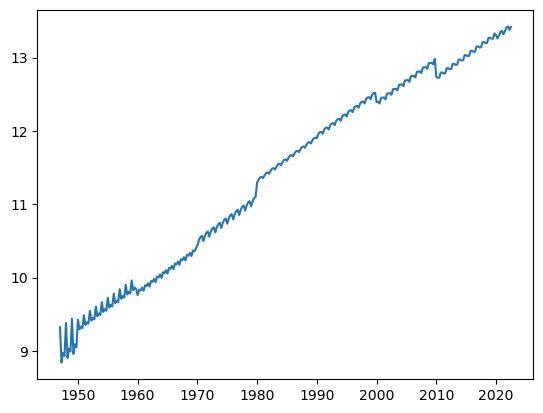

In [43]:
plt.plot(df.index, decade_res.predict())

We can see there is essentially no seasonal wiggling left after we include the decade dummies. But we also see that the levels of the series are very different between 1960-1970, 1980-2000, and 2010-2020. Did we perhaps go too far? Hard to say.

<AxesSubplot: xlabel='DATE'>

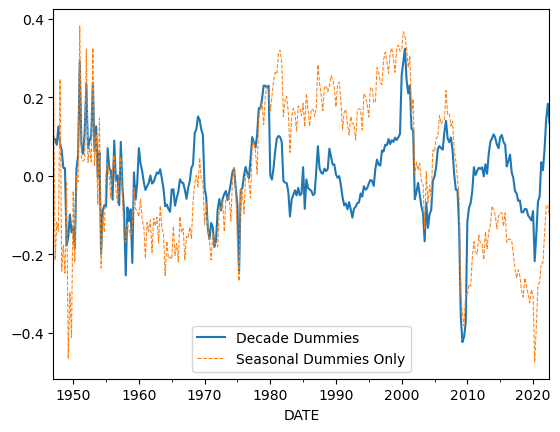

In [48]:
decade_res.resid.plot(label='Decade Dummies', legend=True)
seasonal_res.resid.plot(label='Seasonal Dummies Only', legend=True, ls='--', lw=0.75)

## Option 2: Decomposition

That was a lot of work, let's see if we can't find something a bit easier.

"Decomposition" refers to breaking a time series into three parts: trend, seasonal, and residuals. 

The simplest way to do this is to use a moving average as a trend and remove it. Then specify a window size for the period, and take the average in the window and use this as a seasonal component. What's left over are the residuals.

This is called "naive decomposition". It's implemented in statsmodels as `sm.tsa.seasonal_decompose`.

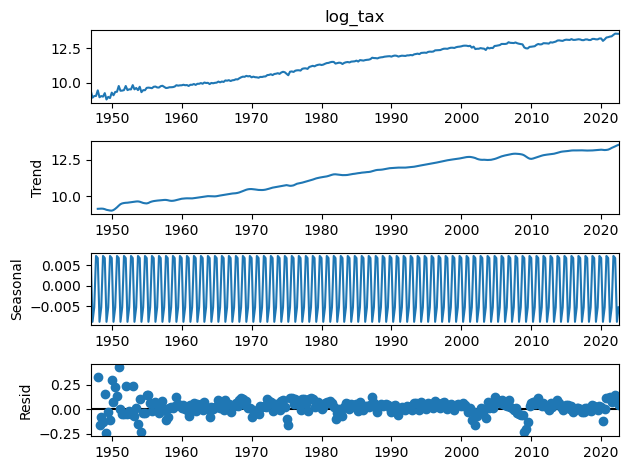

In [49]:
naive_res = sm.tsa.seasonal_decompose(df.log_tax, period=4, two_sided=False)
naive_res.plot();

Using this method, we have to make some choices. The seasonal is quite weak, like what we found with OLS. If we plot them together, we can see it's acutally weaker than the OLS seasonal (between -0.005 and 0.005) whereas OLS was between -0.020 and 0. 

Why the difference? Everything comes from how the trend is estimated. We can see that the trend is changing quite frequently in the naive decomposition (it uses a rolling mean). Do we believe that this is the true trend in the data, or is it also taking out some of the structural variance we want to model?

More hard questions to answer. Let's try another approach.

<AxesSubplot: xlabel='DATE'>

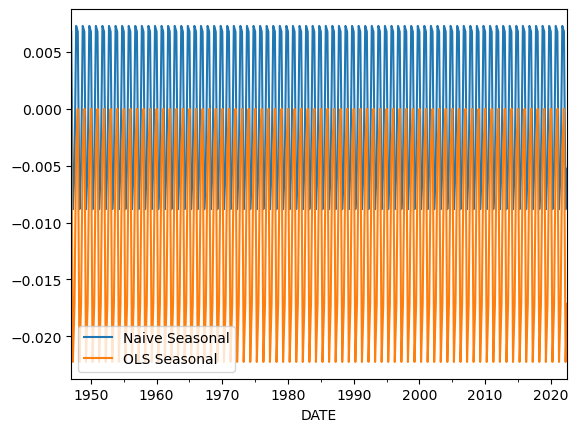

In [56]:
q_cols = ['quarter_2', 'quarter_3', 'quarter_4'] 
naive_res.seasonal.plot(label='Naive Seasonal', legend=True)
(X[q_cols] @ seasonal_res.params[q_cols]).plot(label='OLS Seasonal', legend=True)

A more sophisticed decomposition technique is called STL. It uses a LOWESS regression (which is just a type of weighted rolling mean) to extract a trend and seasonal.

STL is definitely better than the naive decomposition. The down side is that you have to specify three parameters: trend, seasonal, and period. These are the window sizes for the rolling weighted averaging. Trend and seasonal have to be odd, and period has to be smaller than trend.

The most important number to choose is `period`. It should match the seaonal size we want, which we know is 4. The others will automatically be set to reasonable defaults based on the choice of period.

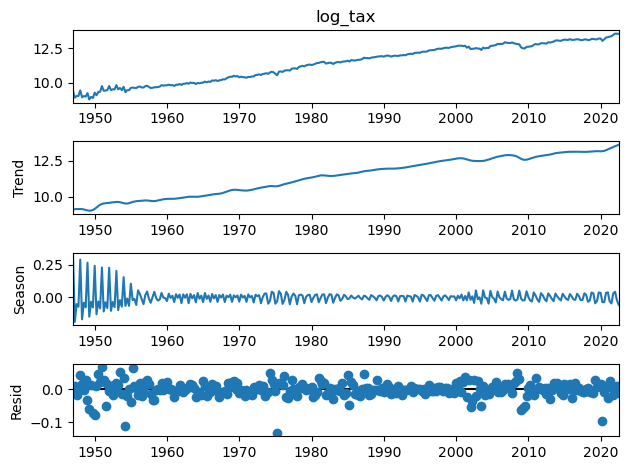

In [58]:
stl_res= sm.tsa.STL(df.log_tax, period=4).fit()
stl_res.plot();

Looking at these plots, we see a couple things. The trend is still very very "wiggly". Maybe we're not so comfortable using it. But the season looks quite nice. It has heterogenous variance, which matches what we saw in the decade-season interaction regression. The scale of the seasonal effect is also non-trivial. We see it goes up to 0.25, which is a lot bigger than the 0.005 we saw with the naive decomposition.

Perhaps we can just take out the seasonal effect estimated by STL, and handle the trend some other way.

To remove the seasonality, just subtract it from the original series. We can see that it removes a lot of the "pops" from the dataset. We can now proceed as normal with removing the trend, either via OLS or HP filter.

<AxesSubplot: xlabel='DATE'>

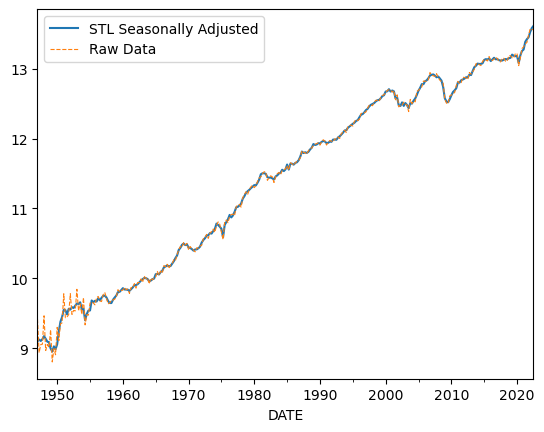

In [60]:
(df.log_tax - stl_res.seasonal).plot(label = 'STL Seasonally Adjusted', legend=True)
df.log_tax.plot(ls='--', lw=0.8, label='Raw Data', legend=True)

We can see that a lot of seasonal fluctuation has been removed, leaving the smoother blue line. From here, we could proceed to detrending via HP filter or OLS, rather than accepting the aggressive STL trend. Or we could also accept the STL trend. The choice is yours as the analyist.